In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition, metrics
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eig

from sgoopT import stationary, mu_factor, eigenval, sg_transmat, sgap
from cmap1dT import SgoopDistance

In [2]:
# data:
filename={}
x={}
y={}
hbias={} 
xbias={} 
ybias={}
weights={}
hist={}
mids={}
prob={}
freeE={}

# MD parameters:
beta=9.5
Rout=100  # (unit: steps/lines)

# metaD parameters:
stride={}
wbias={}
delta_beta={}

# SGOOP parameters:
rc_bin={}
wells={}
th={}
coeff={}
rc={}
pi={}
MU={}
S={}
E={}

### Read data

In [41]:
data_array = np.loadtxt('traj.txt', unpack=True)
x, y = data_array

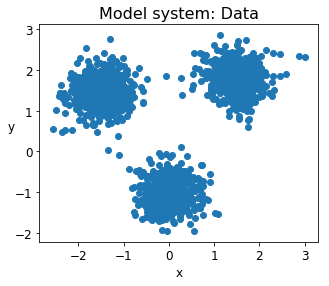

In [42]:
plt.figure(figsize=(5,4))
plt.title('Model system: Data', size=16)
plt.scatter(x, y)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('x', size=12)
plt.ylabel('y', size=12).set_rotation(0)
plt.show()

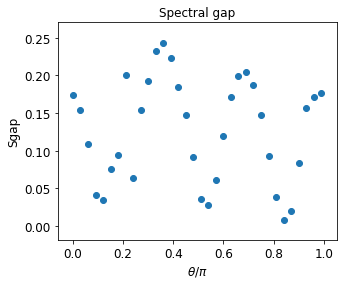

Maximal sgap at 
th=0.36pi
  =64.8(degrees)


In [72]:
# parameters:
rc_bin['0']=20
wells['0']=3
num_pt=34
rc_interval=0.03
coeff['i']=np.zeros(2)

# data:
sgap_arr=np.zeros(num_pt)
i_arr=np.arange(num_pt)
for i in i_arr:
    th['i'] = np.pi*i*rc_interval
    coeff['i'][0], coeff['i'][1] = np.cos(th['i']), np.sin(th['i'])
    rc['unbiased'] = coeff['i'][0]*x + coeff['i'][1]*y
    rc['i'] = coeff['i'][0]*x + coeff['i'][1]*y
    
    pi['i'], _ = stationary(rc['i'], rc_bin=rc_bin['0'])
    MU['i'] = mu_factor(rc['unbiased'], pi['i'], rc_bin=rc_bin['0'], max_d=1)
    S['i'] = sg_transmat(rc_bin['0'], pi['i'], MU['i'], max_d=1)
    sgap_arr[i] = sgap(S['i'], wells['0'])
    
# Plottings:
fig, ax=plt.subplots(figsize=(5,4))
ax.set_title('Spectral gap')
ax.scatter(rc_interval*i_arr, sgap_arr)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('$\\theta/\pi$', size=12)
ax.set_ylabel('Sgap', size=12)

plt.show()

print('Maximal sgap at \nth={}pi\n  ={}(degrees)'.format(rc_interval*np.argmax(sgap_arr), rc_interval*np.argmax(sgap_arr)*180))


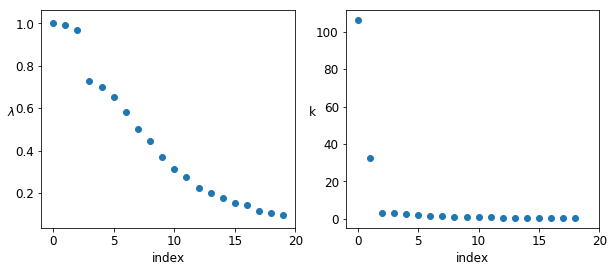

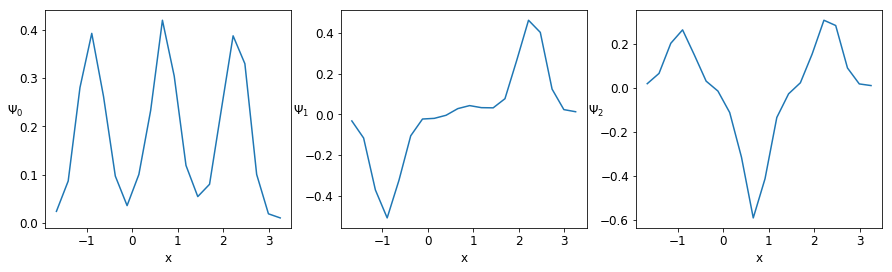

In [44]:
# parameters:
rc_bin['1']=20
th['1']=0.36*np.pi
coeff['1']=np.zeros(2)
coeff['1'][0], coeff['1'][1] = np.cos(th['1']), np.sin(th['1'])

# data:
rc['unbiased'] = coeff['1'][0]*x + coeff['1'][1]*y
rc['1'] = coeff['1'][0]*x + coeff['1'][1]*y
hist_sg=np.histogram(rc['1'], bins=rc_bin['1'])
mids_sg=0.5*(hist_sg[1][1:]+hist_sg[1][:-1])

pi['1'], _ = stationary(rc['1'], rc_bin=rc_bin['1'])
MU['1'] = mu_factor(rc['unbiased'], pi['1'], rc_bin=rc_bin['1'], max_d=1)
S['1'] = sg_transmat(rc_bin['1'], pi['1'], MU['1'], max_d=1)
E['1'] = eigenval(S['1']) # E[1]=eigenvals, exp_eigenvals, eigenvectors

k, W_sg, V_sg = E['1']

# Plottings:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

ax[0].title('exp(k)')
ax[0].scatter(np.arange(len(W_sg)), W_sg)
ax[1].title('Eigenvalues: k')
ax[1].scatter(np.arange(len(W_sg[1:])), -1/k[1:])

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('index', size=12)
ax[0].set_ylabel('$\lambda$', size=12).set_rotation(0)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('index', size=12)
ax[1].set_ylabel('k', size=12).set_rotation(0)
ax[1].set_xlim(-1,20)

plt.show()


# first left eigenvector:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)
for i in range(3):
    if i==0: V_sg[:,i] = np.abs(V_sg[:,i])
    ax[i].plot(mids_sg, V_sg[:,i].real)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel('x', size=12)
    ax[i].set_ylabel('$\Psi_{}$'.format(i), size=12).set_rotation(0)

plt.show()

# Diffusion map with spatially discritized rc as input

Firstly spatially discretizing rc and get mid points by doing histogram.

In [45]:
# parameters:
rc_bin['1']=20
th['1']=0.36*np.pi
coeff['1']=np.zeros(2)
coeff['1'][0], coeff['1'][1] = np.cos(th['1']), np.sin(th['1'])

# data:
rc['1'] = coeff['1'][0]*x + coeff['1'][1]*y

hist=np.histogram(rc['1'], bins=20)
mids_d=0.5*(hist[1][1:]+hist[1][:-1])

Calculating the Euclidean distances between the mid points as coordinates

In [46]:
X=np.vstack((mids_d, mids_d)).T
d = metrics.euclidean_distances(X)

Perform the epsilon test using the Euclidean distances

Text(0, 0.5, '$\\log(\\sum{A_{ij}})$')

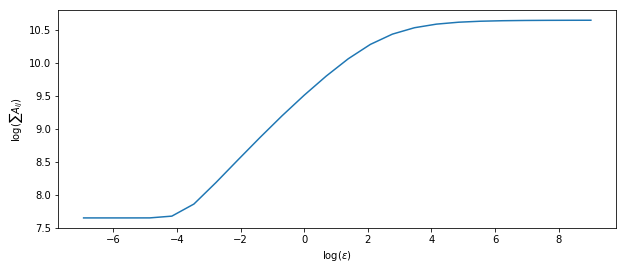

In [47]:
# Values of epsilon in base 2 we want to scan. 
eps = np.power(2., np.arange(-10.,14.,1))

# Pre-allocate array containing sum(Aij). 
Aij = np.zeros(eps.shape)

# Loop through values of epsilon and evaluate matrix sum.
for i in range(len(eps)): 
    A = np.exp(-d**2/(2.*eps[i]))
    Ac=A*hist[0]
    Aij[i] = Ac.sum()

plt.figure(figsize=(10,4))
plt.plot(np.log(eps), np.log(Aij))
plt.xlabel('$\log(\epsilon)$')
plt.ylabel('$\log(\sum{A_{ij}})$')
plt.show()

Compute eigenvalues and eigenvectors of diffusion map with histogram counts as reweighting factors.

In [48]:
# From the plot above we see that 1 is a good choice. 
eps = 1.

# Generate final matrix A, and row normalized matrix M. 
A = metrics.pairwise.rbf_kernel(X, gamma=1./(2.*eps))
Ac=A*hist[0]
M = Ac/Ac.sum(axis=1, keepdims=True)

# Get the eigenvalues/vectors of M. 
# We normalize by the first eigenvector. 
W, U, V = eig(M, left=True)
idx = W.argsort()[::-1]
W_d = W[idx]
U_d = U[:,idx]
V_d = V[:,idx]

From the eigenvalue plot, we can also see the spectral gap between third and forth eigenvalues.

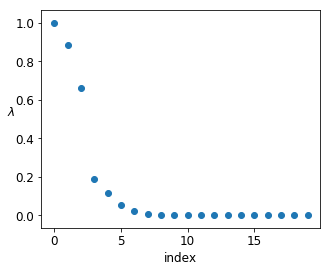

In [49]:
plt.rcParams['figure.figsize']=(5,4)
plt.scatter(np.arange(len(W_d)), W_d.real)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('index', size=12)
plt.ylabel('$\lambda$', size=12).set_rotation(0)
plt.show()

Plotting left eigenvectors show similar profiles

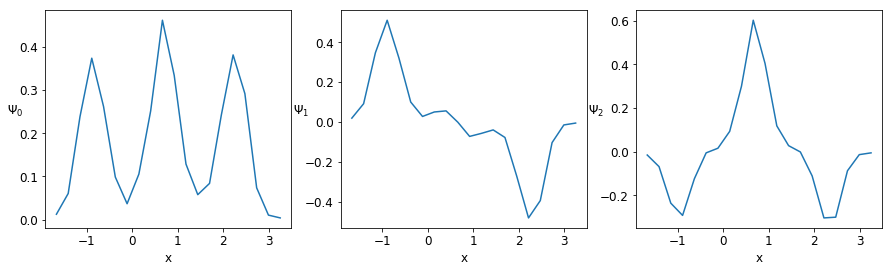

In [50]:
# Left eigenvectors:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

ax=ax.flatten()

for i in range(3):
    if i==0: U_d[:,i] = np.abs(U_d[:,i])
    ax[i].plot(mids_d, U_d[:,i].real)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel('x', size=12)
    ax[i].set_ylabel('$\Psi_{}$'.format(i), size=12).set_rotation(0)

plt.show()

The first right eigenvector is a constant vector as expected.

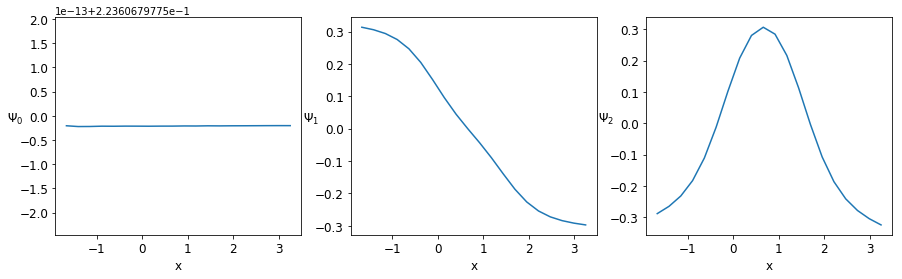

In [51]:
# Right eigenvectors:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

for i in range(3):
    if i==0: V_d[:,i] = np.abs(V_d[:,i])
    ax[i].plot(mids_d, V_d[:,i].real)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel('x', size=12)
    ax[i].set_ylabel('$\Psi_{}$'.format(i), size=12).set_rotation(0)

plt.show()

# Diffusion map using rc values without spatially discretization

This time we do not make histogram. We will simply calculate rc values as linear combination of x and y, and then use the rc values directly.

In [76]:
# parameters:
rc_bin['1']=20
th['1']=0.36*np.pi
coeff['1']=np.zeros(2)
coeff['1'][0], coeff['1'][1] = np.cos(th['1']), np.sin(th['1'])

# data:
rc['1'] = coeff['1'][0]*x + coeff['1'][1]*y

X=np.vstack((rc['1'], rc['1'])).T
d = metrics.euclidean_distances(X)

Perform epsilon test

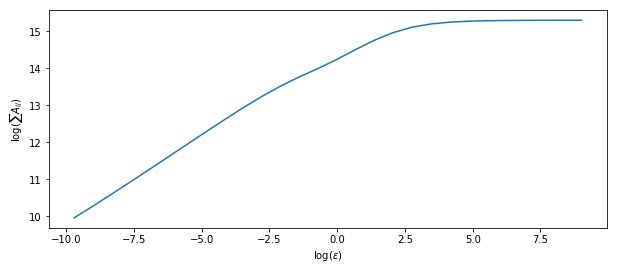

In [78]:
eps = np.power(2., np.arange(-14.,14.,1))
Aij = np.zeros(eps.shape)

for i in range(len(eps)): 
    A = np.exp(-d**2/(2.*eps[i]))
    Aij[i] = A.sum()
    
plt.figure(figsize=(10,4))
plt.plot(np.log(eps), np.log(Aij))
plt.xlabel('$\log(\epsilon)$')
plt.ylabel('$\log(\sum{A_{ij}})$')
plt.show()

Compute eigenvalues and eigenvectors of diffusion map.

In [55]:
# From the plot above we see that 0.5 is probably a good choice. 
eps = 0.5

# Generate final matrix A, and row normalized matrix M. 
A = np.exp(-d**2/(2.*eps)) # d=pairwise distances between data points
M = A/A.sum(axis=1, keepdims=True)

# Get the eigenvalues/vectors of M. 
# We normalize by the first eigenvector. 
W, U, V = eig(M, left=True)
idx = W.argsort()[::-1]
W_c = W[idx]
U_c = U[:,idx]
V_c = V[:,idx]

The eigenvalue plot still show the spectral gap between third and forth eigenvalues. The profile looks even similar to SGOOP.

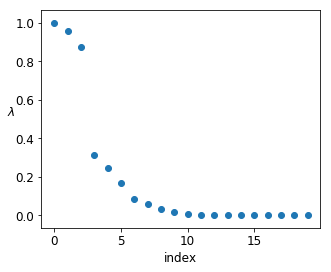

In [56]:
plt.rcParams['figure.figsize']=(5,4)
plt.scatter(np.arange(len(W_c[:20])), W_c[:20].real)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('index', size=12)
plt.ylabel('$\lambda$', size=12).set_rotation(0)
plt.show()

Left eigenvector

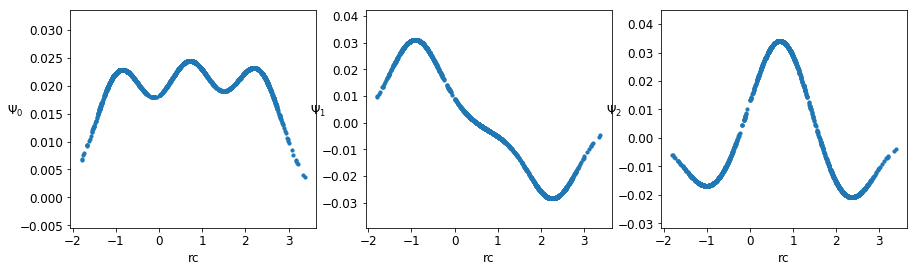

In [57]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

ax=ax.flatten()

for i in range(3):
    if i==0: U_c[:,i] = np.abs(U_c[:,i])
    ax[i].scatter(rc['1'], U_c[:,i].real, s=10)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel('rc', size=12)
    ax[i].set_ylabel('$\Psi_{}$'.format(i), size=12).set_rotation(0)

plt.show()

Right eigenvectors

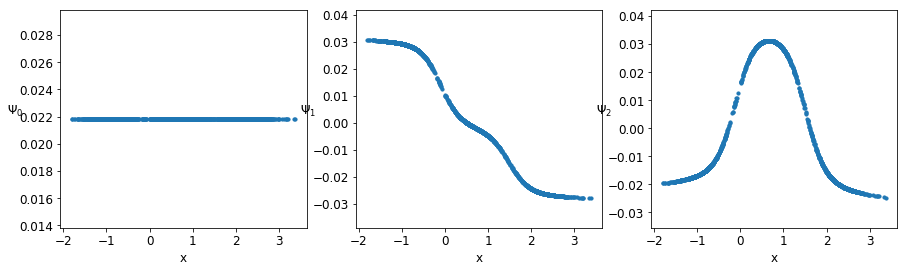

In [58]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

for i in range(3):
    if i==0: V_c[:,i] = np.abs(V_c[:,i])
    ax[i].scatter(rc['1'], V_c[:,i].real, s=10)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel('x', size=12)
    ax[i].set_ylabel('$\Psi_{}$'.format(i), size=12).set_rotation(0)

plt.show()

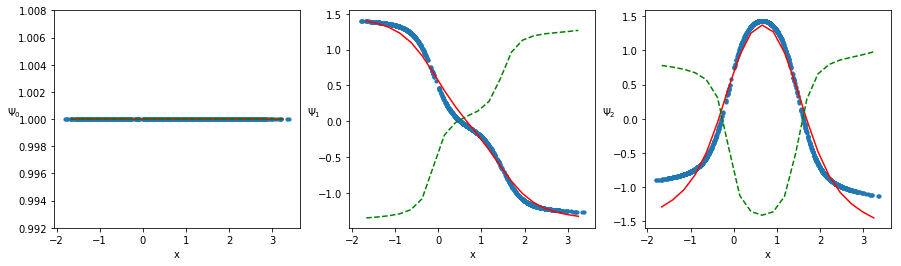

In [59]:
# first left eigenvector:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

for i in range(3):
    ax[i].scatter(rc['1'], (V_c[:,i]/V_c[:,0]).real, s=10)
    ax[i].plot(mids_d, (V_d[:,i]/V_d[:,0]).real, 'r-')
    ax[i].plot(mids_sg, (V_sg[:,i]/V_sg[:,0]).real, 'g--')
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('$\Psi_{}$'.format(i)).set_rotation(0)

plt.show()

# Test kinetic distance

In [60]:
def find_idx(mids, x):
    """find index of x in mids."""
    return np.argmin(np.abs(mids-x))

In [61]:
# metas = np.array([[1.5,1.5], [0.0, 0.0], [-1.5,-1.5]])
metas = np.array([[1.5,1.8], [0.0, -1.5], [-1.5,1.5]])

# Euclidean distance
Ed_AB = np.linalg.norm(metas[0]-metas[1])
Ed_BC = np.linalg.norm(metas[1]-metas[2])
Ed_AC = np.linalg.norm(metas[0]-metas[2])

print(Ed_AB**2)
print(Ed_BC**2)
print(Ed_AC**2)

13.14
11.250000000000002
9.09


/Users/lina492375qw1188/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


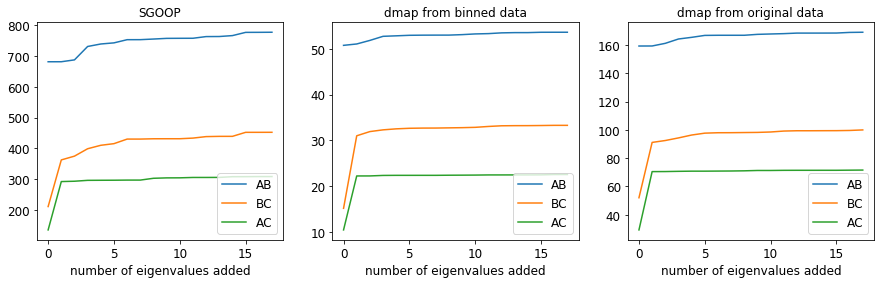

In [62]:
A=metas[0]
B=metas[1]
C=metas[2]
pA = coeff['1'][0]*A[0] + coeff['1'][1]*A[1]
pB = coeff['1'][0]*B[0] + coeff['1'][1]*B[1]
pC = coeff['1'][0]*C[0] + coeff['1'][1]*C[1]

idx_A_sg = find_idx(mids_sg, pA)
idx_B_sg = find_idx(mids_sg, pB)
idx_C_sg = find_idx(mids_sg, pC)

idx_A_d = find_idx(mids_d, pA)
idx_B_d = find_idx(mids_d, pB)
idx_C_d = find_idx(mids_d, pC)

idx_A_c = find_idx(rc['1'], pA)
idx_B_c = find_idx(rc['1'], pB)
idx_C_c = find_idx(rc['1'], pC)


def commuted_sg(idx1, idx2, n):
    """
    Calculate commute distance using n sgoop eigenvalues and eigenvectors.
    """
    return np.sum([(1/(-k[i]))
                   *(V_sg[:,i][idx1]/V_sg[:,0][idx1]-V_sg[:,i][idx2]/V_sg[:,0][idx2])**2
                   for i in range(1,n)])

def kinetic_d(idx1, idx2, n):
    """
    Calculate commute distance using n sgoop eigenvalues and eigenvectors.
    """
    return np.sum([(-1/np.log(W_d[i]))
                   *(V_d[:,i][idx1]/V_d[:,0][idx1]-V_d[:,i][idx2]/V_d[:,0][idx2])**2
                   for i in range(1,n)])

def kinetic_c(idx1, idx2, n):
    """
    Calculate commute distance using n sgoop eigenvalues and eigenvectors.
    """
    return np.sum([(-1/np.log(W_c[i]))
                   *(V_c[:,i][idx1]/V_c[:,0][idx1]-V_c[:,i][idx2]/V_c[:,0][idx2])**2
                   for i in range(1,n)])


Kd_AB_sg=[]
Kd_BC_sg=[]
Kd_AC_sg=[]

Kd_AB_d=[]
Kd_BC_d=[]
Kd_AC_d=[]

Kd_AB_c=[]
Kd_BC_c=[]
Kd_AC_c=[]

for i in range(2, 20):
    Kd_AB_sg.append(commuted_sg(idx_A_sg, idx_B_sg, i))
    Kd_BC_sg.append(commuted_sg(idx_B_sg, idx_C_sg, i))
    Kd_AC_sg.append(commuted_sg(idx_A_sg, idx_C_sg, i))
    
    Kd_AB_d.append(kinetic_d(idx_A_d, idx_B_d, i))
    Kd_BC_d.append(kinetic_d(idx_B_d, idx_C_d, i))
    Kd_AC_d.append(kinetic_d(idx_A_d, idx_C_d, i))
    
    Kd_AB_c.append(kinetic_c(idx_A_c, idx_B_c, i))
    Kd_BC_c.append(kinetic_c(idx_B_c, idx_C_c, i))
    Kd_AC_c.append(kinetic_c(idx_A_c, idx_C_c, i))
    
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

ax[0].plot(Kd_AB_sg, label='AB')
ax[0].plot(Kd_BC_sg, label='BC')
ax[0].plot(Kd_AC_sg, label='AC')

ax[1].plot(Kd_AB_d, label='AB')
ax[1].plot(Kd_BC_d, label='BC')
ax[1].plot(Kd_AC_d, label='AC')

ax[2].plot(Kd_AB_c, label='AB')
ax[2].plot(Kd_BC_c, label='BC')
ax[2].plot(Kd_AC_c, label='AC')

ax[0].set_title('SGOOP')
ax[1].set_title('dmap from binned data')
ax[2].set_title('dmap from original data')

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_xlabel('number of eigenvalues added', size=12)
ax[1].set_xlabel('number of eigenvalues added', size=12)
ax[2].set_xlabel('number of eigenvalues added', size=12)

ax[0].legend(loc='lower right', fontsize=12)
ax[1].legend(loc='lower right', fontsize=12)
ax[2].legend(loc='lower right', fontsize=12)

plt.show()


# Diffusion map with 2-dim coordinates (x,y) directly

In [63]:
def find_diffusion_matrix(X=None, alpha=0.15):
    """Function to find the diffusion matrix P
        
        >Parameters:
        alpha - to be used for gaussian kernel function
        X - feature matrix as numpy array
        
        >Returns:
        P_prime, P, Di, K, D_left
    """
    alpha = alpha
        
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2/alpha)
    
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))
    
    return P_prime, P, Di, K, D_left

def find_diffusion_map(P_prime, D_left, n_eign=4):
    """Function to find the diffusion coordinates in the diffusion space
        
        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively 
                    the dimensions to keep in diffusion space.
        
        >Returns:
        Diffusion_map as np.array object
    """   
    n_eign = n_eign
    
    eigenValues, eigenVectors = eig(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    diffusion_coordinates = np.matmul(D_left, eigenVectors)
    
    return diffusion_coordinates[:,:n_eign]

In [64]:
X=np.vstack((data_array, data_array)).T
d = metrics.euclidean_distances(X)

Compute eigenvalues and eigenvectors of diffusion map.

In [65]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, 0.5)

W, U, V = eig(P_prime, left=True)
idx = W.real.argsort()[::-1]
W = W[idx]
U = U[:,idx]
V = V[:,idx]


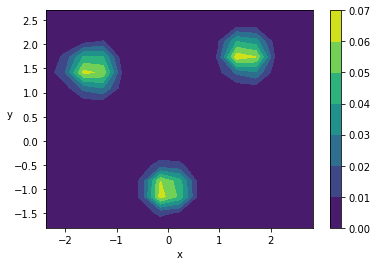

In [87]:
hist = np.histogram2d(x, y, weights=V[:,0].real, bins=15)
prob = hist[0].T/np.sum(hist[0])
mids_x = 0.5*(hist[1][1:]+hist[1][:-1])
mids_y = 0.5*(hist[2][1:]+hist[2][:-1])

plt.rcParams['figure.figsize']=(6,4)
plt.contourf(mids_x, mids_y, prob+1e-5)
plt.xlabel('x')
plt.ylabel('y').set_rotation(0)
plt.colorbar()
plt.show()

In [67]:
diffusion_coordinates = find_diffusion_map(P_prime, D_left).real

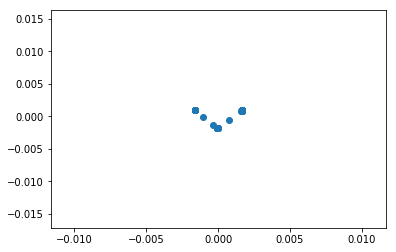

In [68]:
plt.scatter(diffusion_coordinates[:,1], diffusion_coordinates[:,2])

# Test kinetic distances

In [69]:
def find_idx2d(data_array, x):
    """find index of x in mids."""
    return np.argmin(np.sum((data_array.T-x)**2, axis=1))

In [70]:
# metas = np.array([[1.5,1.5], [0.0, 0.0], [-1.5,-1.5]])
metas = np.array([[1.5,1.8], [0.0, -1.5], [-1.5,1.5]])

# Euclidean distance
Ed_AB = np.linalg.norm(metas[0]-metas[1])

Ed_BC = np.linalg.norm(metas[1]-metas[2])

Ed_AC = np.linalg.norm(metas[0]-metas[2])
print(Ed_AB**2)
print(Ed_BC**2)
print(Ed_AC**2)

13.14
11.250000000000002
9.09


/Users/lina492375qw1188/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


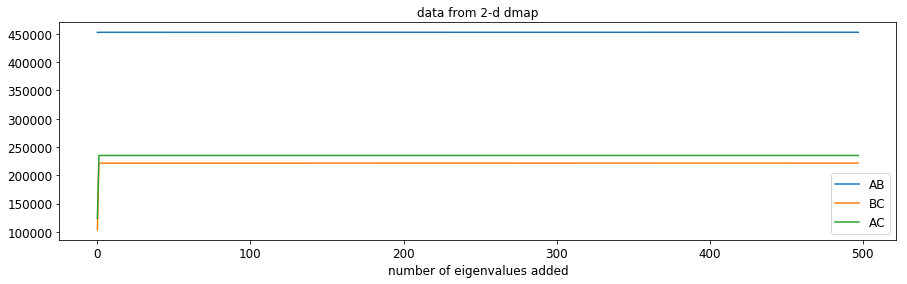

In [71]:
A=metas[0]
B=metas[1]
C=metas[2]

idx_A_c = find_idx2d(data_array, A)
idx_B_c = find_idx2d(data_array, B)
idx_C_c = find_idx2d(data_array, C)

def kinetic_c(idx1, idx2, n):
    """
    Calculate commute distance using n sgoop eigenvalues and eigenvectors.
    """
    return np.sum([(-1/np.log(W[i]))
                   *(V[:,i][idx1]/V[:,0][idx1]-V[:,i][idx2]/V[:,0][idx2])**2
                   for i in range(1,n)])

Kd_AB_c=[]
Kd_BC_c=[]
Kd_AC_c=[]

for i in range(2, 500):
    
    Kd_AB_c.append(kinetic_c(idx_A_c, idx_B_c, i))
    Kd_BC_c.append(kinetic_c(idx_B_c, idx_C_c, i))
    Kd_AC_c.append(kinetic_c(idx_A_c, idx_C_c, i))
    
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=1)

ax.plot(Kd_AB_c, label='AB')
ax.plot(Kd_BC_c, label='BC')
ax.plot(Kd_AC_c, label='AC')

ax.set_title('data from 2-d dmap')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('number of eigenvalues added', size=12)
ax.legend(loc='lower right', fontsize=12)

plt.show()

